# Data processing


In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/home/fulim/learning/HuggingFace/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Training without using the Trainer class


1. Remove the columns corresponding to values the model does not expect (like the sentence1 and sentence2 columns).
2. Rename the column label to labels (because the model expects the argument to be named labels).
3. Set the format of the datasets so they return PyTorch tensors instead of lists.


In [2]:
tokenized_datasets = tokenized_datasets.remove_columns(
    ["sentence1", "sentence2", "idx"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'token_type_ids', 'attention_mask']

# Dataloaders use to iterate over batches


In [3]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)

To quickly check there is no mistake in the data processing, we can inspect a batch like this:


In [4]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 66]),
 'token_type_ids': torch.Size([8, 66]),
 'attention_mask': torch.Size([8, 66])}

actual shapes will probably be slightly different each time your run, since we set shuffle=True for the training dataloader and we are padding to the maximum length inside the batch


In [5]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=2)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

# Model Test (Return the loss and logits 8x2)


In [6]:
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(0.8667, grad_fn=<NllLossBackward0>) torch.Size([8, 2])


# Optimzer : AdamW


In [7]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

/home/fulim/learning/HuggingFace/.env/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Scheduler

a linear decay from the maximum value (5e-5) to 0.

To properly define it, we need to know the number of training steps we will take, which is the number of epochs we want to run multiplied by the number of training batches (which is the length of our training dataloader). The Trainer uses three epochs by default, so we will follow that:


In [8]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

1377


# Define Device : GPU (Much Faster than CPU)


In [9]:
import torch

device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

# Training Loop


add a progress bar over our number of training steps, using the tqdm library


In [10]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

100%|██████████| 1377/1377 [12:23<00:00,  1.44it/s]

# Evaluation Loop


As we did earlier, we will use a metric provided by the 🤗 Evaluate library. We’ve already seen the metric.compute() method, but metrics can actually accumulate batches for us as we go over the prediction loop with the method add_batch(). Once we have accumulated all the batches, we can get the final result with metric.compute(). Here’s how to implement all of this in an evaluation loop:


In [11]:
import evaluate

metric = evaluate.load("glue", "mrpc")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.8578431372549019, 'f1': 0.903010033444816}

# Complete Code


In [ ]:
from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=2)
optimizer = AdamW(model.parameters(), lr=3e-5)

device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

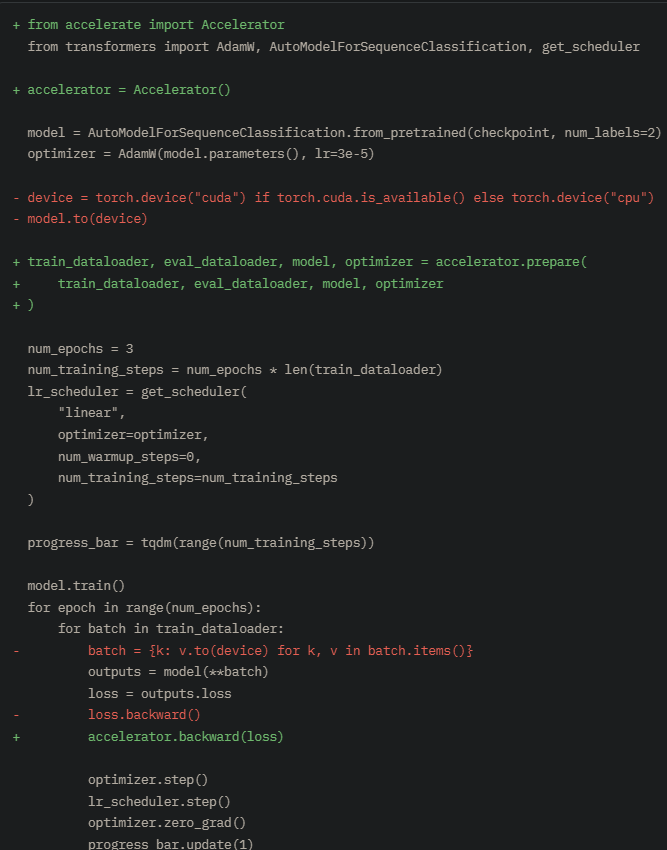


The first line to add is the import line. The second line instantiates an Accelerator object that will look at the environment and initialize the proper distributed setup. 🤗 Accelerate handles the device placement for you, so you can remove the lines that put the model on the device (or, if you prefer, change them to use accelerator.device instead of device).

Then the main bulk of the work is done in the line that sends the dataloaders, the model, and the optimizer to accelerator.prepare(). This will wrap those objects in the proper container to make sure your distributed training works as intended. The remaining changes to make are removing the line that puts the batch on the device (again, if you want to keep this you can just change it to use accelerator.device) and replacing loss.backward() with accelerator.backward(loss).


# Replace by Accelerator

🤗 Accelerate library, with just a few adjustments we can enable distributed training on multiple GPUs or TPUs.


In [12]:
def training_function():
    from accelerate import Accelerator
    from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler

    accelerator = Accelerator()

    model = AutoModelForSequenceClassification.from_pretrained(
        checkpoint, num_labels=2)
    optimizer = AdamW(model.parameters(), lr=3e-5)

    train_dl, eval_dl, model, optimizer = accelerator.prepare(
        train_dataloader, eval_dataloader, model, optimizer
    )

    num_epochs = 3
    num_training_steps = num_epochs * len(train_dl)
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    progress_bar = tqdm(range(num_training_steps))

    model.train()
    for epoch in range(num_epochs):
        for batch in train_dl:
            outputs = model(**batch)
            loss = outputs.loss
            accelerator.backward(loss)

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

In [14]:
from accelerate import notebook_launcher

notebook_launcher(training_function, num_processes=1)

Launching training on one GPU.


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

# How to Run Accelerator


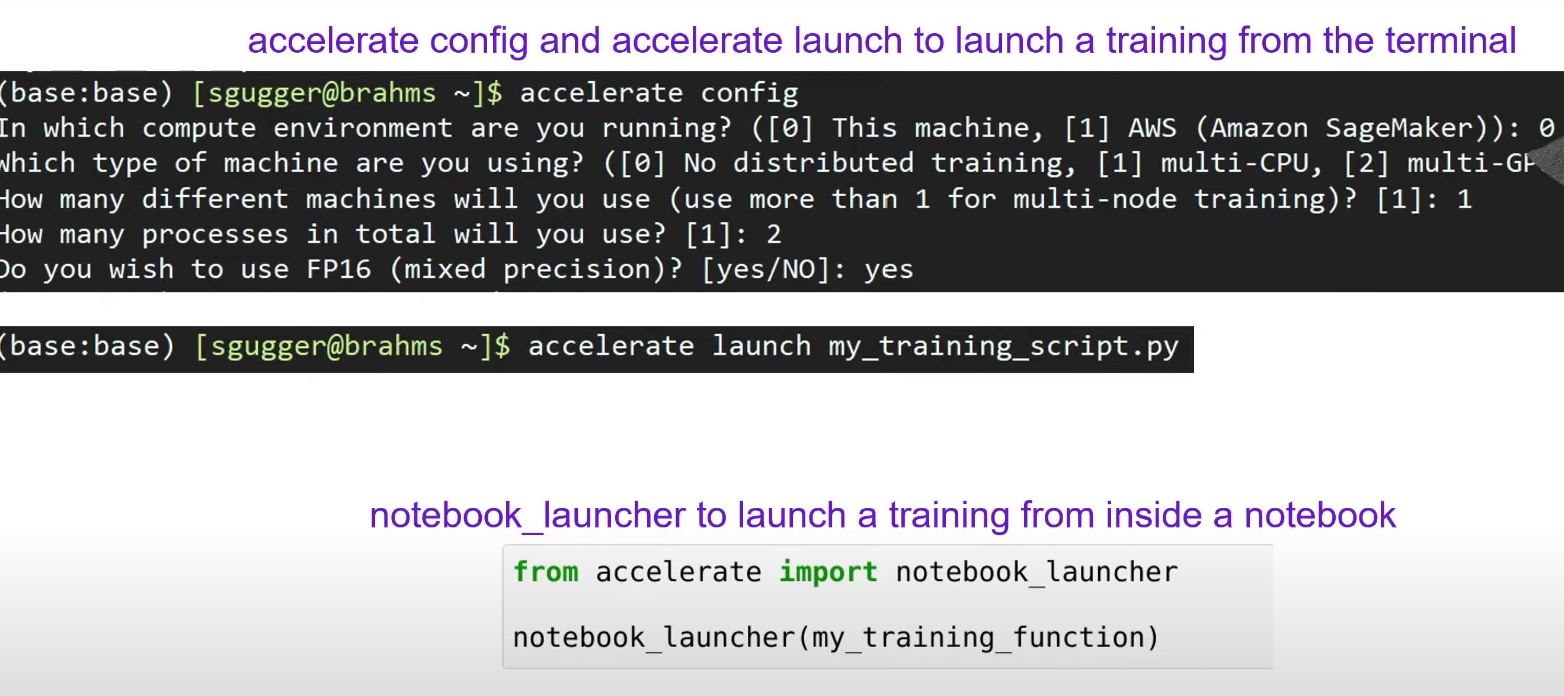


Putting this in a train.py script will make that script runnable on any kind of distributed setup. To try it out in your distributed setup, run the command:

```
accelerate config
```

which will prompt you to answer a few questions and dump your answers in a configuration file used by this command:

```
accelerate launch train.py
```

which will launch the distributed training.

If you want to try this in a Notebook (for instance, to test it with TPUs on Colab), just paste the code in a training_function() and run a last cell with:

```
from accelerate import notebook_launcher

notebook_launcher(training_function)
```
